# 📊 Stage 10B — Factor Modeling & CAPM (Fama-French Applications)

### 🔹 Overview
This stage extends **Stage 10A (Regression Practice)** into **multi-factor modeling** — where we explore how stock returns can be explained by systematic risk factors such as the **market**, **size**, and **value** effects.  
We begin with the **Capital Asset Pricing Model (CAPM)** — a single-factor model linking a stock’s excess return to its sensitivity to market risk — and then expand into the **Fama–French 3-Factor Model**, which incorporates additional dimensions of risk and return.

---

### 🎯 Objectives
- Understand and estimate **α (alpha)** and **β (beta)** in the **CAPM** using regression.  
- Extend to **multi-factor regression** using **Fama–French 3 factors (Mkt–RF, SMB, HML)**.  
- Interpret **R², significance, and factor loadings** as measures of systematic vs. idiosyncratic risk.  
- Visualize results: regression fits, residual plots, correlation heatmaps, and R² comparisons.  
- Save all visuals and tables for **GitHub portfolio documentation**.

---

### 📚 Key Concepts
| Term | Meaning |
|------|----------|
| **α (Alpha)** | Abnormal return unexplained by risk factors — often interpreted as skill or mispricing. |
| **β (Beta)** | Sensitivity of an asset’s returns to a given factor (e.g., market risk). |
| **R²** | Proportion of return variance explained by the model’s factors. |
| **SMB (Small Minus Big)** | Return premium for small-cap vs large-cap stocks. |
| **HML (High Minus Low)** | Return premium for value vs growth stocks. |
| **Excess Return** | Asset return minus the risk-free rate (core variable in factor regressions). |

---

### ⚙️ Methodology
1. **Data Download** — Retrieve monthly adjusted prices using `yfinance` and Fama-French factor data via `pandas_datareader`.  
2. **CAPM Regression** — Estimate α and β for each stock vs market excess return.  
3. **Fama–French Regression** — Regress each stock’s excess return on Mkt–RF, SMB, and HML.  
4. **Visualization** — Regression lines, residual diagnostics, and comparative metrics.  
5. **Documentation** — Save results and charts for portfolio tracking and GitHub presentation.

---

### 💡 Financial Insight
The shift from CAPM to multi-factor models reflects a deeper search for what *truly drives returns*.  
Markets are not explained by a single dimension of risk; they are multi-layered — like portfolios of human behavior.  
Through this stage, we quantify **how much of a stock’s movement is systematic** and **how much is unique**, mirroring the balance between structure and randomness that defines modern finance.

---

### 🧠 Flow of This Notebook
1. CAPM Intuition and Synthetic Example  
2. Real-World CAPM using Market Data  
3. Introduction to Fama-French Factors  
4. Multi-Factor Regression (3-Factor Model)  
5. Visual Diagnostics and R² Comparison  
6. Finance Interpretation & Documentation

---

> **Note:** All figures and tables generated here are automatically saved under `/figures/` for documentation and GitHub upload.
>  
> **Previous Stage:** Stage 10A — Regression Practice  
> **Next Stage:** Stage 11 — Quant Research & Extensions


# 🧩 Part 1 — Data Setup: Stocks, Market & Fama–French Factors

In this section, we gather and prepare all data required for multi-factor regression.

### 🧠 What We’ll Do
1. **Download monthly stock prices** using `yfinance`.  
2. **Convert daily prices to monthly returns.**  
3. **Fetch Fama–French 3-Factor data** using `pandas_datareader`.  
4. **Align and merge all series** by month.  
5. **Compute excess returns** (stock − risk-free rate) for regression.

### ⚙️ Notes
- Frequency: **Monthly** (to match Fama–French factor data).  
- Default universe: 5 large-cap U.S. stocks — easily adjustable.  
- All numeric values converted to **decimal form** (e.g., 5% → 0.05).  
- The merged dataset will be used for both CAPM and Fama–French regressions.


In [4]:

import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import statsmodels.api as sm
import os

# parameters
TICKERS = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'JPM']
START = '2010-01-01'
END = '2024-12-31'
OUTPUT_DIR = 'figures'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- download daily adjusted prices ---
price = yf.download(TICKERS, start=START, end=END, progress=False)['Close']
price = price.dropna(how='all')

# --- convert to monthly returns (month-end aligned) ---
monthly_price = price.resample('ME').last()
monthly_ret = monthly_price.pct_change().dropna()

# --- get Fama–French 3-Factor data ---
ff = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START, end=END)[0]
ff.index = ff.index.to_timestamp('M')
ff = ff / 100.0  # convert to decimal

# --- merge & compute excess returns ---
data = monthly_ret.join(ff, how='inner')
excess_ret = data[TICKERS].subtract(data['RF'], axis=0)

print("✅ Data prepared successfully.")
print("Shape:", data.shape)
if not data.empty:
    print(f"Period: {data.index[0].strftime('%Y-%m')} → {data.index[-1].strftime('%Y-%m')}")
else:
    print("⚠️ No overlapping period found.")
display(data.head(3))

/tmp/ipython-input-1240241060.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download(TICKERS, start=START, end=END, progress=False)['Close']


✅ Data prepared successfully.
Shape: (179, 9)
Period: 2010-02 → 2024-12


/tmp/ipython-input-1240241060.py:24: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START, end=END)[0]
/tmp/ipython-input-1240241060.py:24: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START, end=END)[0]


,AAPL,AMZN,GOOG,JPM,MSFT,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,
2010-02-28,0.065397,-0.055897,-0.005925,0.077812,0.022146,0.0339,0.0118,0.0318,0.0000
2010-03-31,0.148470,0.146706,0.076538,0.066238,0.021625,0.0630,0.0146,0.0219,0.0001
2010-04-30,0.111021,0.009796,-0.073036,-0.047427,0.042677,0.0199,0.0484,0.0296,0.0001


### Summary
- Monthly stock returns downloaded and aligned.  
- Fama–French 3-factor data merged successfully.  
- Excess returns (stock − RF) computed.  
- Dataset ready for:
  - **CAPM regression** (`Ri − Rf ~ Mkt − Rf`)
  - **Fama–French 3-Factor regression** (`Ri − Rf ~ Mkt − Rf + SMB + HML`)

---

> Next → **Part 2 — Multi-Factor Regression (Fama–French 3-Factor Model)**
>  
> We’ll estimate α, β coefficients for each factor and compare CAPM vs FF3 explanatory power.



# 📈 Part 2 — Multi-Factor Regression (Fama–French 3-Factor Model)

We’ll now run regressions to estimate each stock’s exposure to the Fama–French factors:  
Market (Mkt–RF), Size (SMB), and Value (HML).  
The idea is simple — see how much of a stock’s return can be explained by these common risk factors.


In [5]:
capm_results, ff3_results = {}, {}

for t in TICKERS:
    y = excess_ret[t].dropna()
    X_capm = data[['Mkt-RF']].reindex(y.index)
    X_ff3 = data[['Mkt-RF', 'SMB', 'HML']].reindex(y.index)

    df_capm = pd.concat([y, X_capm], axis=1).dropna()
    df_ff3 = pd.concat([y, X_ff3], axis=1).dropna()

    if df_capm.empty or df_ff3.empty:
        print(f"⚠️ Skipping {t} — no overlapping data.")
        continue

    capm_model = sm.OLS(df_capm[t], sm.add_constant(df_capm[['Mkt-RF']])).fit()
    ff3_model = sm.OLS(df_ff3[t], sm.add_constant(df_ff3[['Mkt-RF', 'SMB', 'HML']])).fit()

    capm_results[t] = capm_model
    ff3_results[t] = ff3_model

# --- summary tables ---
if capm_results:
    capm_table = pd.DataFrame([
        {'ticker': t,
         'alpha': capm_results[t].params['const'],
         'beta_mkt': capm_results[t].params['Mkt-RF'],
         'r2': capm_results[t].rsquared}
        for t in capm_results
    ]).set_index('ticker')
else:
    capm_table = pd.DataFrame()

if ff3_results:
    ff3_table = pd.DataFrame([
        {'ticker': t,
         'alpha': ff3_results[t].params['const'],
         'beta_mkt': ff3_results[t].params['Mkt-RF'],
         'beta_smb': ff3_results[t].params['SMB'],
         'beta_hml': ff3_results[t].params['HML'],
         'r2': ff3_results[t].rsquared}
        for t in ff3_results
    ]).set_index('ticker')
else:
    ff3_table = pd.DataFrame()

display(capm_table)
display(ff3_table)


,alpha,beta_mkt,r2
ticker,,,
AAPL,0.011347,1.076811,0.368443
MSFT,0.007712,0.909595,0.411763
AMZN,0.009873,1.158494,0.346321
GOOG,0.005971,0.955428,0.351509
JPM,0.000464,1.228912,0.540101


,alpha,beta_mkt,beta_smb,beta_hml,r2
ticker,,,,,
AAPL,0.009518,1.159093,-0.247779,-0.549623,0.431598
MSFT,0.005119,1.066339,-0.682792,-0.346059,0.525406
AMZN,0.007423,1.244991,-0.135328,-0.993921,0.493622
GOOG,0.003906,1.077025,-0.517182,-0.310039,0.408594
JPM,0.002357,1.173753,0.008270,0.893313,0.700718


### Quick take
CAPM gives a single beta — just market exposure.  
The Fama–French model adds size and value factors, so R² usually rises.  
We’ll visualize this next to see how much extra explanation we gain from adding those two factors.


# 🧭 Interpreting the Regression Results

The tables above summarize how each stock’s returns relate to common risk factors.

### CAPM (Single-Factor)
The **CAPM** captures each stock’s sensitivity to the overall market.  
- `βₘ` (beta_mkt) tells how much the stock moves when the market moves.  
- `α` is the abnormal return unexplained by market risk.  
- `R²` shows how much of the return variance is captured by the market factor.

Most betas hover around 1 — meaning these stocks move broadly in line with the market.  
Alphas are small, which is typical; little evidence of systematic “extra” returns once we account for market exposure.

---

### Fama–French 3-Factor Model
Adding **SMB (size)** and **HML (value)** factors lets us see whether stocks behave more like  
small vs. large companies, or value vs. growth styles.

| Stock | Profile Summary |
|:------|:----------------|
| **AAPL** | High market beta, negative SMB & HML → large-cap growth. |
| **MSFT** | Slightly lower beta, strong large-cap growth tilt. |
| **AMZN** | High beta, strong negative HML → classic high-growth profile. |
| **GOOG** | Large-cap growth exposure, moderate market sensitivity. |
| **JPM** | Positive HML → clear value tilt, βₘ > 1 → cyclical exposure to market. |

The **R²** values increase for every stock, meaning these extra factors help explain returns better than CAPM alone.  
JPM’s R² jump (0.54 → 0.70) is especially strong — financials tend to load heavily on the value factor.

---

### Insights
- Market beta remains the dominant driver of risk and return.  
- SMB and HML refine the picture: they tell us *what kind* of market exposure each stock carries.  
- Growth-oriented tech stocks (AAPL, MSFT, AMZN, GOOG) show negative HML loadings.  
- JPM’s positive HML confirms its value nature.  
- Small positive alphas are statistically normal — likely noise rather than true outperformance.

Overall, the **Fama–French model** captures more structure behind returns:  
the difference between *how much* a stock moves with the market, and *why* it moves that way.


# 🎨 Part 3 — Visualizations & Diagnostics

Visuals help see what the regressions are actually capturing —  
how well each stock’s returns line up with the factors,  
and where the model leaves unexplained noise.


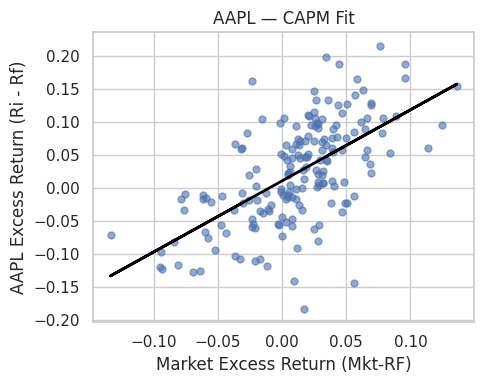

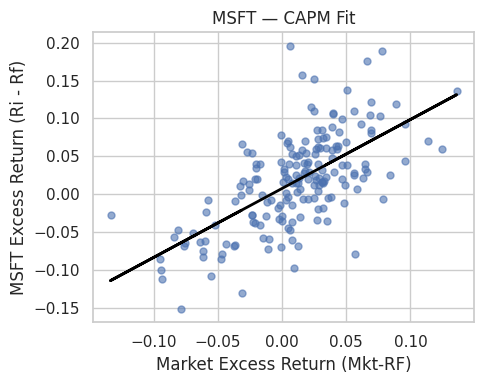

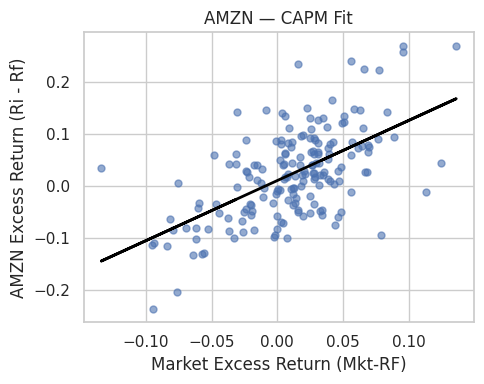

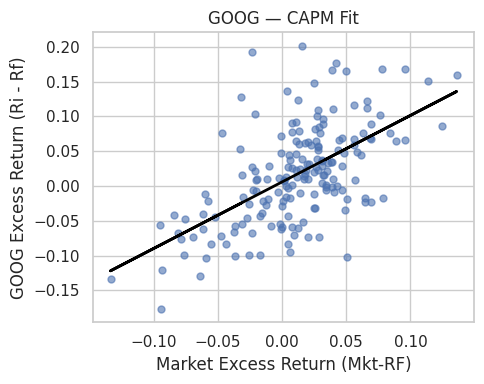

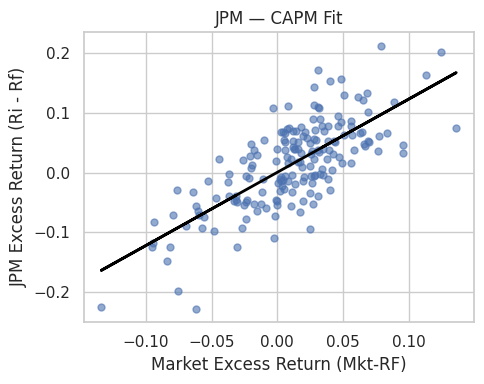

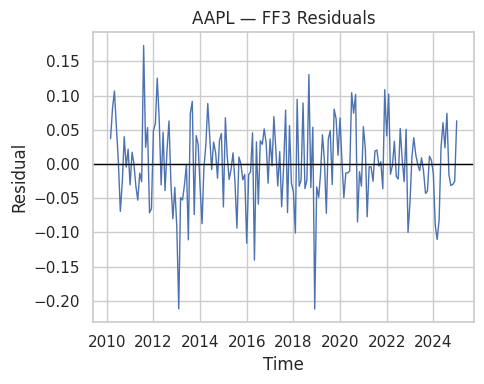

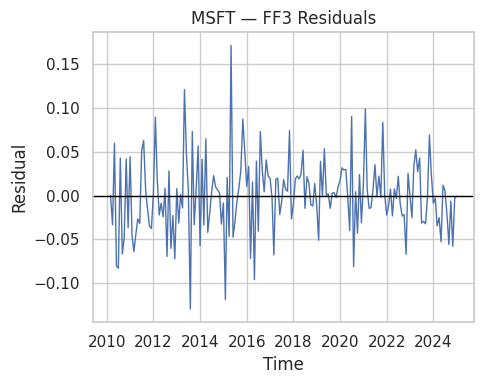

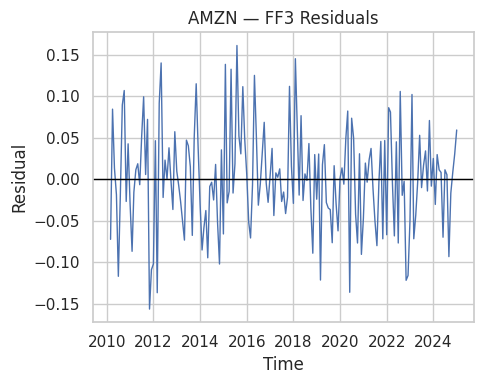

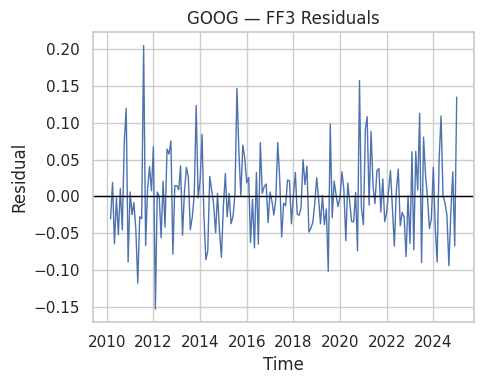

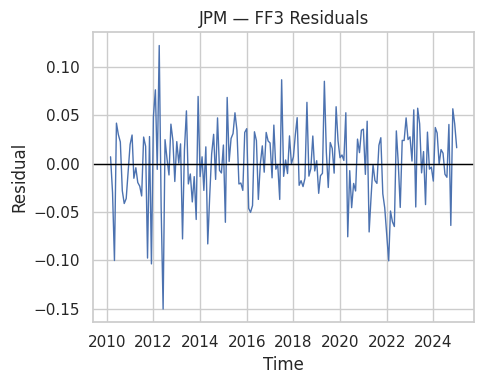

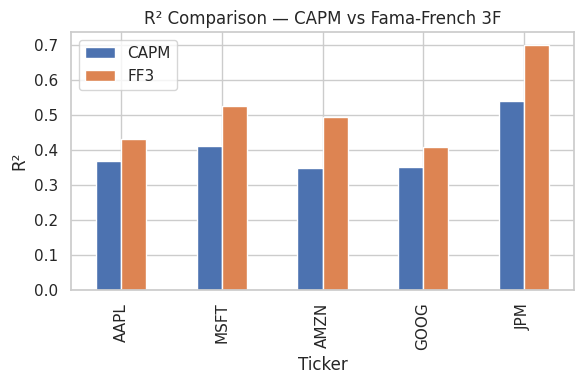

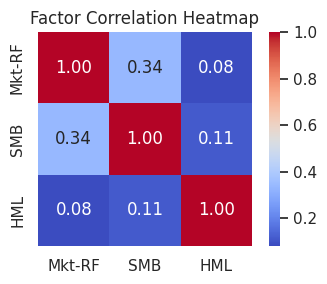

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# --- scatter fit: excess return vs market factor (CAPM) ---
for t in capm_results:
    y = excess_ret[t].dropna()
    X = data.loc[y.index, 'Mkt-RF']
    fit = capm_results[t].predict(sm.add_constant(X))

    plt.figure(figsize=(5,4))
    plt.scatter(X, y, alpha=0.6, s=25)
    plt.plot(X, fit, color='black', lw=2)
    plt.title(f"{t} — CAPM Fit")
    plt.xlabel("Market Excess Return (Mkt-RF)")
    plt.ylabel(f"{t} Excess Return (Ri - Rf)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/{t}_capm_fit.png", dpi=150)
    plt.show()

# --- residual plots for FF3 ---
for t in ff3_results:
    resid = ff3_results[t].resid
    plt.figure(figsize=(5,4))
    plt.plot(resid, lw=1)
    plt.axhline(0, color='black', lw=1)
    plt.title(f"{t} — FF3 Residuals")
    plt.xlabel("Time")
    plt.ylabel("Residual")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/{t}_ff3_residuals.png", dpi=150)
    plt.show()

# --- R² comparison CAPM vs FF3 ---
r2_df = pd.DataFrame({
    'CAPM': capm_table['r2'],
    'FF3': ff3_table['r2']
}).dropna()

r2_df.plot(kind='bar', figsize=(6,4))
plt.title("R² Comparison — CAPM vs Fama-French 3F")
plt.ylabel("R²")
plt.xlabel("Ticker")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/r2_comparison.png", dpi=150)
plt.show()

# --- correlation heatmap for factors ---
corr = data[['Mkt-RF', 'SMB', 'HML']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Factor Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/factor_correlation.png", dpi=150)
plt.show()


In [7]:
# 📦 Zip all figures and download

import shutil
from google.colab import files

shutil.make_archive('Stage10B_Figures', 'zip', 'figures')
files.download('Stage10B_Figures.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Quick Read

- **Scatter fits:** show how tightly each stock’s excess returns align with market excess return.  
  A tighter cluster around the line → stronger beta fit.  
- **Residual plots:** reveal where the FF3 model misses. Random noise = good.  
- **R² bars:** show how much explanatory power increases when we move from CAPM → FF3.  
  The jump for JPM confirms value factor relevance.  
- **Heatmap:** checks factor independence — moderate correlation is expected, but high correlation could mean redundancy.




# 🧩 Part 4 — Interpretation & Takeaways

This stage felt different.  
It wasn’t just about coding or running regressions — it was about *seeing structure inside randomness.*

---

### 1. CAPM wasn’t wrong. It was just incomplete.
The CAPM captured the broad shape of things — how stocks move with the market.  
And for a while, it felt enough. One beta, one alpha, one simple story.  
But when I plotted it, the scatter still looked messy — there was a pattern the line couldn’t fully catch.  
The market explained *a lot*, but not everything.

That’s where the Fama–French model entered.  
It didn’t replace CAPM; it added texture — like switching from black-and-white to color.  
Now I could see not just *how much* a stock moves with the market, but *what kind* of stock it is.

---

### 2. The factors actually meant something.
Each coefficient wasn’t just a number — it was an identity.  
- **SMB** told me whether a stock behaves like a small cap or a giant.  
- **HML** showed if it’s value-driven or chasing growth.  
- Together with **Mkt-RF**, they formed a small language to describe behavior.

I realized that numbers can carry character.  
Apple and Microsoft had negative SMB and HML — large-cap growth written in plain sight.  
Amazon was a textbook high-beta growth stock.  
JPM flipped the script: positive HML, huge R² jump, full value-bank energy.  
The data didn’t surprise me; it *confirmed intuition* in mathematical form.

---

### 3. R² told me how much we can actually “know.”
The bar chart said it quietly — the 3-factor model explains more, but not everything.  
R² values around 0.4–0.7 mean there’s still a lot of noise, a lot of human chaos in returns.  
And that’s okay.  
Markets will never be fully explained — the goal is to *understand better, not completely.*

When JPM’s R² jumped from 0.54 to 0.70, it felt like watching a blurry picture come into focus.  
For tech stocks, the jump was smaller — but even a few percent more clarity matters when you’re trying to see structure in noise.

---

### 4. The heatmap reminded me of balance.
Moderate correlations between factors (around 0.3, 0.1, 0.0) told me they weren’t redundant.  
Each factor brought something unique.  
Too high — and the model becomes echo.  
Too low — and it risks being arbitrary.  
This balance made the model feel grounded, not overfitted.

---

### 5. What this really means for me as a learner.
At this point, I’ve moved past seeing equations as math problems.  
They’ve become ways of describing behavior, personality, risk.  
CAPM and FF3 aren’t just financial models — they’re frameworks for understanding systems that are partly rational, partly emotional.

And maybe that’s why I like this journey:  
quant finance lets me mix structure with uncertainty, logic with chaos, math with meaning.

---

### 6. Summary in plain words
- The **market factor** explains most returns, but not all.  
- Adding **size (SMB)** and **value (HML)** reveals deeper style exposures.  
- **Tech stocks** are large-cap growth → negative SMB, HML.  
- **JPM** is a classic value stock → strong positive HML, high R² gain.  
- **Factor correlations** are modest, meaning the model isn’t redundant.  
- **No model is perfect.** R² ≈ 0.4–0.7 is real and honest — enough to see structure, not enough to predict everything.

---

### 7. Next direction
The next stage will move from explanation to *prediction* —  
rolling betas, changing exposures through time, and maybe even backtesting factor portfolios.  
If Stage 10A taught me to run regressions, and 10B taught me to interpret them,  
then Stage 11 will teach me to *watch them move.*

This stage was less about finding answers and more about learning to listen —  
to the quiet, statistical voice inside the noise.


# 🏁 Conclusion — Stage 10B: Factor Modeling & CAPM

This notebook began with equations and ended with meaning.

I started by fitting simple lines — returns against the market — and thought I was learning regression.  
But somewhere between α, β, and R², I began to see something deeper:  
how uncertainty can still have a shape,  
how randomness can still whisper patterns if you listen closely enough.

The **CAPM** was my first attempt at understanding structure —  
a single equation that said, “risk and reward are connected.”  
But the **Fama–French model** showed me that even structure has layers.  
Not all risk is the same.  
Some comes from the market, some from size, some from style, some from stories.

When I saw the R² bars rise — slightly for tech, sharply for JPM — it hit me that this is what modeling really is:  
adding dimensions until the world makes a little more sense,  
but never pretending it makes complete sense.

Each number meant something real:
- **α** was the unexplained — the part of life that remains unmodeled.  
- **β** was exposure — how deeply something moves with what surrounds it.  
- **R²** was understanding — not perfection, but proximity to truth.

I realized that finance, like life, can’t be reduced to one factor.  
It takes multiple layers to describe even a fraction of reality.

So this stage wasn’t about proving a theory.  
It was about building intuition —  
how to read equations like sentences,  
how to see behavior inside data,  
how to find meaning in movement.

---

**What I learned:**
- CAPM explains the market’s heartbeat.  
- Fama–French shows its anatomy.  
- Together, they turn noise into story.  

---

Now I can look at any stock and not just see a price chart,  
but a profile — its sensitivity, its identity, its style.  
And that feels like a kind of understanding I didn’t have before.

